In [1]:
import pandas as pd
import numpy as np
from scipy import spatial
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import fiona
import statistics
import contextily as cx

In [2]:
mypath = '/home/selihadji/Documenti/papers/Platoon_II/trips/'

In [3]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [4]:
def filterSubstr(lists, substr):
    return [x for x in lists if substr in x]

searchString = '2022_09_15'
onlyfiles_15_09 = filterSubstr(onlyfiles, searchString)
onlyfiles_15_09

searchString1 = '9_5'
onlyfiles1 = filterSubstr(onlyfiles_15_09, searchString1)
onlyfiles1

searchString2 = '10_00'
onlyfiles2 = filterSubstr(onlyfiles_15_09, searchString2)
onlyfiles = onlyfiles1 + onlyfiles2
onlyfiles

['2022_09_15_RG Logi Jeep_09_59_10_19_d5ff3df8-39ae-447a-a46d-6f572e433f70.csv',
 '2022_09_15_RW2 Logi Jeep_09_59_10_19_7c743b0f-d227-4577-8f9f-c9c28c4e9d4d.csv',
 '2022_09_15_PS Skylark Test_10_00_10_19_de7305f7-023c-41d9-96c1-3844151d8eb9.csv']

In [5]:
allfiles = []
for i in range(len(onlyfiles)):
    df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
    df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
    df['driver'] = str(onlyfiles[i])[11:13]
    coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
    alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
    allfiles.append(df)
alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)

In [6]:
alldata['data'] = alldata['Time[ms]'].dt.date

In [7]:
alldata["data"] = pd.to_datetime(alldata["data"])

In [8]:
alldata_RW = alldata[alldata.driver == 'RW']
alldata_PS = alldata[alldata.driver == 'PS']
alldata_RG = alldata[alldata.driver == 'RG']

In [9]:
allfiles = []
for i in range(len(onlyfiles)):
    df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
    df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
    df['driver'] = str(onlyfiles[i])[11:13]
    coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
    alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
    allfiles.append(df)

In [10]:
alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)

In [11]:
alldata.driver.unique()

array(['RG', 'RW', 'PS'], dtype=object)

In [12]:
alldata_SORTED = alldata.sort_values(by = 'Time[ms]').reset_index(drop=True)

In [13]:
alldata_SORTED_cut = alldata_SORTED.iloc[50:].dropna().reset_index(drop=True)

In [14]:
alldata_SORTED_cut['Time'] = pd.to_datetime(alldata_SORTED_cut['Time[ms]'].dt.strftime('%H:%M:%S'))

In [15]:
rw = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'RW'].reset_index(drop=True).drop_duplicates()
rg = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'RG'].reset_index(drop=True).drop_duplicates()
ps = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'PS'].reset_index(drop=True).drop_duplicates()

In [16]:
from haversine import haversine, Unit
import haversine as hs

In [17]:
platoon_alldist = []
platoon_all_CO2 = []

platoon_all_lat_dist = []
platoon_all_lon_dist = []

platoon_all_lat_CO2 = []
platoon_all_lon_CO2 = []

#rw
#rg
#ps


for i in range(len(rw)):
    platoon_lat_dist = []
    platoon_lon_dist = []
    platoon_lat_CO2 = []
    platoon_lon_CO2 = []
    platoon_dist = []
    CO2_max = []
    dist_mat = []
    
    rw_ = rw.iloc[i]
    
    df_array1 = (rw_.Latitude, rw_.Longitude)

    rg_ = rg[rg['Time'] > rw_['Time']].reset_index(drop=True)
    df_array2 = list(zip(rg_.Latitude, rg_.Longitude))[0:60]
        
    for j in range(len(df_array2)):
        dist_mat.append(hs.haversine(df_array1,df_array2[j],unit=Unit.METERS))

    rg_mindist = min(dist_mat)
    rg_mindist_index = dist_mat.index(rg_mindist)

    platoon_dist.append(rg_mindist)

    platoon_lat_dist.append(rg_.iloc[rg_mindist_index]["Latitude"])
    platoon_lon_dist.append(rg_.iloc[rg_mindist_index]["Longitude"])

    CO2 = []
    CO2.append(rg_.iloc[0]['CO2[kg]'])
    try:
        CO2.extend(list(rg_.iloc[1:21]['CO2[kg]']))
    except:
        pass
    
    rg_maxCO2 = max(CO2)
    rg_maxCO2_index = CO2.index(rg_maxCO2)
    CO2_max.append(rg_.reset_index(drop=True).iloc[rg_maxCO2_index]['CO2[kg]'])
    platoon_lat_CO2.append(rg_.reset_index(drop=True).iloc[rg_maxCO2_index]["Latitude"])
    platoon_lon_CO2.append(rg_.reset_index(drop=True).iloc[rg_maxCO2_index]["Longitude"])    


    ps_ = ps[ps['Time'] > rg_['Time'][rg_mindist_index]].reset_index(drop=True)
    df_array3 = list(zip(ps_.Latitude, ps_.Longitude))[0:60]        
    
    dist_mat = []

    for j in range(len(df_array3)):
        dist_mat.append(hs.haversine(df_array2[rg_mindist_index],df_array3[j],unit=Unit.METERS))

    ps_mindist = min(dist_mat)
    ps_mindist_index = dist_mat.index(ps_mindist)

    platoon_dist.append(ps_mindist)
    platoon_lat_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Latitude"])
    platoon_lon_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Longitude"])    

    CO2 = []

    CO2.append(ps_.iloc[0]['CO2[kg]'])
    try:
        CO2.extend(list(ps_.iloc[1:21]['CO2[kg]']))
    except:
        pass
    ps_maxCO2 = max(CO2)
    ps_maxCO2_index = CO2.index(ps_maxCO2)
    CO2_max.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]['CO2[kg]'])
    platoon_lat_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Latitude"])
    platoon_lon_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Longitude"])  

      
    platoon_all_lat_dist.append(platoon_lat_dist)
    platoon_all_lon_dist.append(platoon_lon_dist)
    platoon_all_lat_CO2.append(platoon_lat_CO2)
    platoon_all_lon_CO2.append(platoon_lon_CO2)
    platoon_alldist.append(platoon_dist)
    platoon_all_CO2.append(CO2_max)

ValueError: min() arg is an empty sequence

<Axes: >

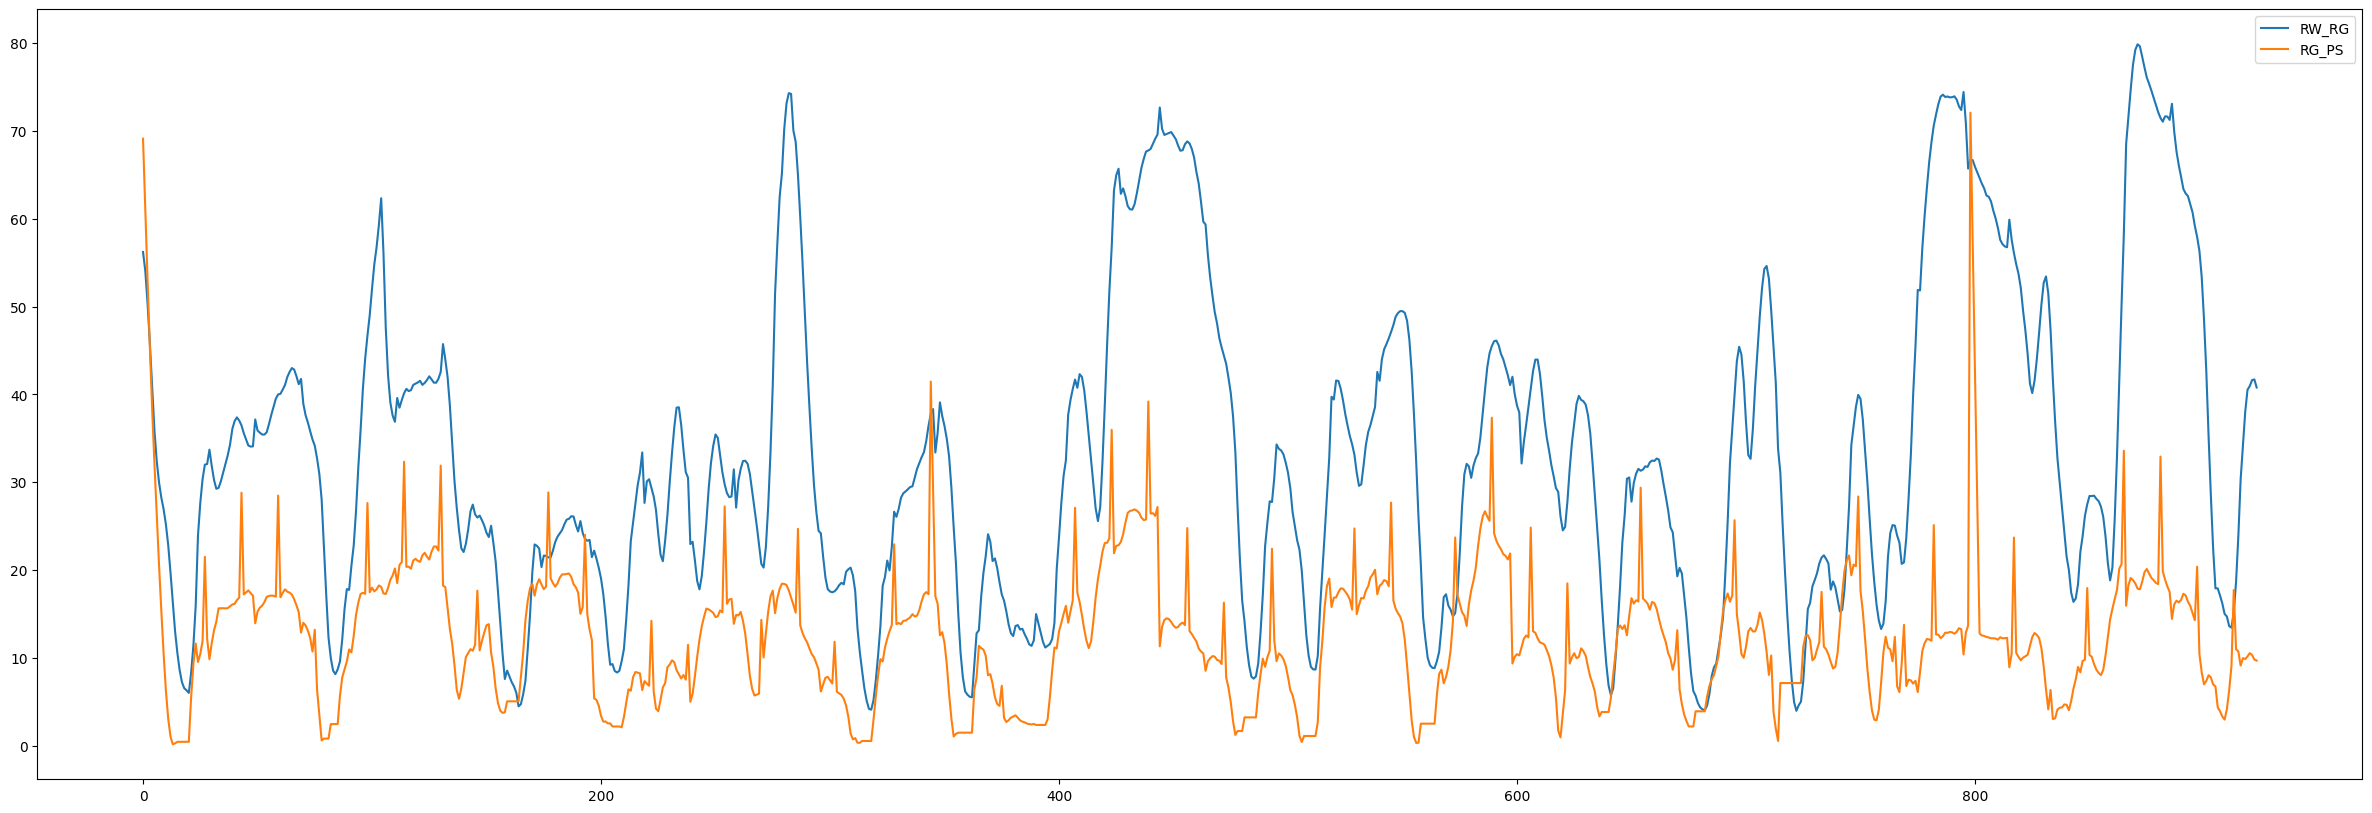

In [20]:
pd.DataFrame(platoon_alldist, columns = ['RW_RG', 'RG_PS']).plot(figsize=(30,10))

In [21]:
dist_v = pd.DataFrame(platoon_alldist, columns = ['RW_RG', 'RG_PS'])
pd.DataFrame(platoon_alldist, columns = ['RW_RG', 'RG_PS']).to_csv('distance_platoon.csv', index=False)

In [22]:
dist_coord = pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1)

In [23]:
pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1).to_csv('platoon_distances_coord.csv', index=False)

In [24]:
infr = pd.read_csv('/home/selihadji/Documenti/papers/Platoon_II/infrast_data_update_.csv', sep=';')
infr.what.unique()

array(['Turn_left', '4-ways intersection', 'Traffic_light', 'Curve',
       'Road_immission', 'Turn_right'], dtype=object)

In [25]:
allveic = []
for k in range(0, len(dist_coord.columns)-1, 2):
    veic = []
    for i in range(len(dist_coord)):
        infra = []
        for j in range(len(infr)):
            inf = (infr.iloc[j].lon,infr.iloc[j].lat)
            distcoor = (dist_coord.iloc[i][str(dist_coord.columns[k+1])], dist_coord.iloc[i][str(dist_coord.columns[k])])
            infra.append(hs.haversine(inf,distcoor,unit=Unit.METERS))
        veic.append(infra)
    allveic.append(veic)

In [26]:
v1 = pd.DataFrame(allveic[0])
v2 = pd.DataFrame(allveic[1])

In [27]:
allfeat = []
for i in range(len(v1)): 
    allfeat.append(list(v1[v1<500].iloc[i].dropna()))
new_v1 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)

In [28]:
allfeat = []
for i in range(len(v2)): 
    allfeat.append(list(v2[v2<500].iloc[i].dropna()))
new_v2 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)

In [29]:
v1.columns = infr.what
v2.columns = infr.what

In [30]:
vlist = []
vlist.append(v1)
vlist.append(v2)

In [31]:
import statsmodels.api as sm

In [32]:
all_X = []
all_y = []

for k in range(len(vlist)):
    feats = []
    v = vlist[k]
    infrast = v.idxmin(axis=1)
    for i in range(len(v)):
        if (v.iloc[i][str(infrast[i])] < 80).any():
            feats.append([infrast[i]])
        else:
            feats.append([])
    new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

    X = new_v.copy()
    y = dist_v[str(dist_v.columns[k])]
    X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
    all_X.append(X)
    all_y.append(y)

all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  RG_PS   R-squared (uncentered):                   0.589
Model:                            OLS   Adj. R-squared (uncentered):              0.587
Method:                 Least Squares   F-statistic:                              219.4
Date:                Tue, 01 Aug 2023   Prob (F-statistic):                   1.68e-173
Time:                        09:39:59   Log-Likelihood:                         -3389.0
No. Observations:                 924   AIC:                                      6790.
Df Residuals:                     918   BIC:                                      6819.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Feat_4-ways intersection     2.5676      6.730      0.382      0.703     -10.641      15.776
Feat_Road_immission          6.4438      1.668      3.863      0.000       3.171       9.717
Feat_Traffic_light           4.4595      0.537      8.298      0.000       3.405       5.514
Feat_Turn_left               3.8180      1.089      3.505      0.000       1.680       5.956
Feat_Turn_right              3.7660      1.259      2.991      0.003       1.295       6.237
old_dist                     0.6016      0.027     22.368      0.000       0.549       0.654
==============================================================================
Omnibus:                      223.712   Durbin-Watson:                   0.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2309.799
Skew:                           0.791   Prob(JB):                         0.00
Kurtosis:                      10.583   Cond. No.                         317.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
results_summary = model.summary()
df = pd.DataFrame.from_records(results_summary.tables[1].data)
header = df.iloc[0]
df = df[1:] # take the data less the header row
df.columns = header
df.to_csv('platoon_II_15_09_10_00_.csv')

In [34]:
platoon_all_CO2_ = pd.DataFrame(platoon_all_CO2, columns = ['RG_LA', 'LA_PS'])
pd.DataFrame(platoon_all_CO2, columns = ['RW_LA', 'LA_PS']).to_csv('CO2_platoon.csv', index=False)

all_X = []
all_y = []

for k in range(len(vlist)):
    feats = []
    v = vlist[k]
    infrast = v.idxmin(axis=1)
    for i in range(len(v)):
        if (v.iloc[i][str(infrast[i])] <80).any():
            feats.append([infrast[i]])
        else:
            feats.append([])
    new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

    X = new_v.copy()
    y = platoon_all_CO2_[str(platoon_all_CO2_.columns[k])]
    X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
    all_X.append(X)
    all_y.append(y)

all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  LA_PS   R-squared (uncentered):                   0.693
Model:                            OLS   Adj. R-squared (uncentered):              0.690
Method:                 Least Squares   F-statistic:                              344.6
Date:                Tue, 01 Aug 2023   Prob (F-statistic):                   4.21e-231
Time:                        09:39:59   Log-Likelihood:                          4234.5
No. Observations:                 924   AIC:                                     -8457.
Df Residuals:                     918   BIC:                                     -8428.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Feat_4-ways intersection     0.0047      0.002      2.695      0.007       0.001       0.008
Feat_Road_immission          0.0024      0.000      5.410      0.000       0.002       0.003
Feat_Traffic_light           0.0033      0.000     23.459      0.000       0.003       0.004
Feat_Turn_left               0.0027      0.000      9.416      0.000       0.002       0.003
Feat_Turn_right              0.0023      0.000      6.988      0.000       0.002       0.003
old_dist                     0.0001   7.02e-06     16.022      0.000    9.87e-05       0.000
==============================================================================
Omnibus:                       19.937   Durbin-Watson:                   0.193
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.139
Skew:                          -0.329   Prob(JB):                     2.57e-05
Kurtosis:                       3.342   Cond. No.                         317.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
results_summary = model.summary()
df = pd.DataFrame.from_records(results_summary.tables[1].data)
header = df.iloc[0]
df = df[1:] # take the data less the header row
df.columns = header
df.to_csv('platoon_II_15_09_10_00_CO2.csv')